# Load Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

df = pd.read_csv("../data/all.csv")
print ("Columns of df: ",  list(enumerate(df.columns)), "\n")

print ("Shape of df: ", df.shape, "\n")

print ("Number of songs having lyrics: ", df['lyrics'].notnull().sum(), "\n")



Columns of df:  [(0, 'Age'), (1, 'Album_Name'), (2, 'Artist'), (3, 'Year'), (4, 'Description'), (5, 'Age Group'), (6, 'Album_ID'), (7, 'Album_Name_Spotify'), (8, 'Artists_Spotify'), (9, 'Track_ID'), (10, 'ISRC'), (11, 'Track_Name'), (12, 'Artists'), (13, 'popularity'), (14, 'preview_url'), (15, 'image_url'), (16, 'danceability'), (17, 'energy'), (18, 'key'), (19, 'loudness'), (20, 'mode'), (21, 'speechiness'), (22, 'acousticness'), (23, 'instrumentalness'), (24, 'liveness'), (25, 'valence'), (26, 'tempo'), (27, 'type'), (28, 'uri'), (29, 'track_href'), (30, 'analysis_url'), (31, 'duration_ms'), (32, 'time_signature'), (33, 'lyrics')] 

Shape of df:  (19560, 34) 

Number of songs having lyrics:  14270 



In [4]:
#df =  df[df['Age']<6]
df = df.dropna(subset=['lyrics'])
df = df.drop_duplicates(subset=['lyrics'])
df = df.reset_index(drop=True)

import re

def remove_disclaimer(string):
    s = re.sub(r'(\*)+ This Lyrics is NOT for Commercial use .*\r\n\([0-9]*\)',"", string)
    return s

df['lyrics'] = df['lyrics'].apply(remove_disclaimer)

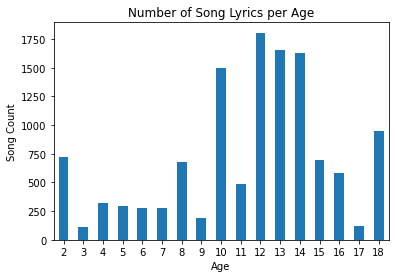

In [7]:
df[df['Age']<5].shape
df.groupby('Age').size().\
    plot.bar(rot=0).\
    set(ylabel='Song Count',
    title='Number of Song Lyrics per Age');

# Text Processing

In [8]:
import spacy
#nlp = spacy.load("en", disable=['parser','ner','tagger', 'textcat'])
nlp = spacy.load("en_core_web_sm",  disable=['parser','ner', 'textcat'])

In [9]:
import re

stopwords = spacy.lang.en.STOP_WORDS
stopwords = stopwords.union(['-pron-', 'oh','ooh','la','don','want'])

def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w\w\w+\b', doc)) 
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if len(w.lemma_)>2 ]


stopwords = set(my_lemmatizer(' '.join(list(stopwords))))



In [10]:
df['lyrics']

0        In old Transylvania when I was a lad\r\nOur ca...
1        Saw a monster in the mirror when I woke up tod...
2        The Big Red Car rolls along the street\r\nAnd ...
3        Every night under the sea, a friendly octopus,...
4        Having fun at the beach\r\nHaving fun at the b...
                               ...                        
12272    Now I don't really care what you call me\r\nJu...
12273    Listen to this track, bitch\r\n\r\nGirl the wa...
12274    My...\r\nYeah, yeah\r\nMmm\r\n\r\nMy life, my ...
12275    Uh, I like a long-haired, thick redbone\r\nOpe...
12276    Rack rack city, bitch\r\nRack rack rack city, ...
Name: lyrics, Length: 12277, dtype: object

# Bag-of-Words Model + K-Mean clustering

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(tokenizer=my_lemmatizer, stop_words=stopwords, 
                     min_df=2, max_df=0.9)
counts = cv.fit_transform(df['lyrics'])

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

In [12]:
cv.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(max_df=0.9, min_df=2,
                stop_words={'about', 'above', 'across', 'after', 'afterwards',
                            'again', 'against', 'all', 'almost', 'alone',
                            'along', 'already', 'also', 'although', 'always',
                            'among', 'amongst', 'amount', 'and', 'another',
                            'any', 'anyhow', 'anyone', 'anything', 'anyway',
                            'anywhere', 'around', 'back', 'because', 'become', ...},
                tokenizer=<function my_lemmatizer at 0x000002831AC1B8B0>)>

In [13]:
from sklearn.cluster import KMeans
number_of_clusters = 5

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(matrix)
kmc_5.cluster_centers_
import numpy as np

number_of_top_words = 10

cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
terms = cv.get_feature_names()

top_words = set()

for i in range(number_of_clusters):
    print('Cluster {}: '.format(i))
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]][::-1]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

Cluster 0: 
like come know man let look ain day time cause 

Cluster 1: 
yeah know like love baby cause hey right let girl 

Cluster 2: 
baby girl wanna know like let hey cause ain love 

Cluster 3: 
know time feel like let way think cause tell away 

Cluster 4: 
love know baby like feel heart need let come cause 



C:\Users\ncche_hrdkov7\anaconda3\envs\nlp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_5.labels_.tolist()
word_df.sample(3)

,ain,away,baby,cause,come,day,feel,girl,heart,hey,...,man,need,right,tell,think,time,wanna,way,yeah,Cluster
11551,0,0,0,0,1,0,0,0,0,0,...,0,0,2,0,0,1,0,1,0,0
8020,0,0,0,0,0,0,2,0,0,0,...,2,2,1,0,0,0,0,0,0,4
5450,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


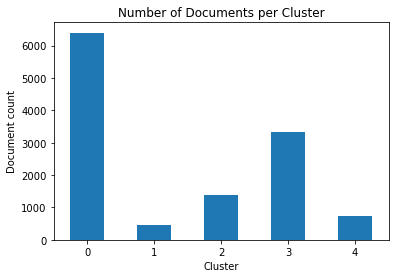

In [15]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

# Latent Dirichlet allocation (LDA)

In [27]:
import gensim

import re
def process_words(texts, stop_words=set()):
    result = []
    for t in texts:
        #t = ' '.join(re.findall(r'\b\w[\w\']+\b', t))
        t = ' '.join(re.findall(r'\b\w\w\w+\b', t))   #only keep word with at least 3 chars

        doc = nlp(t)
        result.append([token.lemma_.lower() for token in doc if token.lemma_.lower() not in stop_words])
    return result

processed_text = process_words(df['lyrics'], stop_words=stopwords.union(
                                ['-pron-', 'oh','ooh','la','don','want', 'like','ain','hey','be','yeah']))

In [28]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))
corpus = [dictionary.doc2bow(t) for t in processed_text]
num_topics = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=117, update_every=1,
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

Number of unique tokens: 24032


In [29]:
lda_model.print_topic(5)


'0.021*"whip" + 0.020*"huh" + 0.019*"roll" + 0.019*"turn" + 0.018*"hot" + 0.016*"boy" + 0.015*"pop" + 0.015*"man" + 0.014*"dem" + 0.014*"hair"'

In [31]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.030*"run" + 0.017*"eye" + 0.015*"away" + 0.013*"look" + 0.011*"fall" + '
  '0.011*"turn" + 0.011*"ground" + 0.010*"know" + 0.009*"sound" + '
  '0.008*"rain"'),
 (1,
  '0.083*"love" + 0.044*"know" + 0.032*"tell" + 0.029*"think" + 0.027*"wanna" '
  '+ 0.020*"need" + 0.018*"time" + 0.016*"do" + 0.016*"cause" + 0.012*"kiss"'),
 (2,
  '0.033*"come" + 0.028*"let" + 0.018*"life" + 0.017*"world" + 0.017*"time" + '
  '0.015*"dream" + 0.014*"heart" + 0.014*"day" + 0.013*"fall" + 0.013*"light"'),
 (3,
  '0.017*"everybody" + 0.017*"big" + 0.012*"let" + 0.012*"play" + 0.012*"shit" '
  '+ 0.010*"know" + 0.010*"jump" + 0.010*"man" + 0.010*"kid" + 0.010*"hit"'),
 (4,
  '0.033*"night" + 0.028*"fuck" + 0.018*"black" + 0.012*"drink" + '
  '0.012*"sleep" + 0.011*"bed" + 0.011*"blow" + 0.010*"woah" + 0.010*"hoe" + '
  '0.010*"come"'),
 (5,
  '0.021*"whip" + 0.020*"huh" + 0.019*"roll" + 0.019*"turn" + 0.018*"hot" + '
  '0.016*"boy" + 0.015*"pop" + 0.015*"man" + 0.014*"dem" + 0.014*"hair"'),
 (6,
 

In [32]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join([x[0] for x in model.show_topic(topic)]))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_Lyrics'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [34]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)
main_topic_df = pd.concat([df[['lyrics','Age']], main_topic_df], axis=1)

main_topic_df.sort_values(by='Percent',ascending=False).head(10)

,lyrics,Age,Dominant_topic,Percent,Processed_Lyrics,Keywords
3937,Oh\r\nCaught in a bad romance\r\nOh\r\nCaught ...,10,1,0.986,"[catch, bad, romance, catch, bad, romance, rah...",love know tell think wanna need time do cause ...
1936,"The situation is critical\r\n(Ha, ha, ha)\r\nY...",7,9,0.985,"[situation, critical, babe, critical, gone, cr...",to going got dance party stop let start way wanna
1213,"Alalo, le, le le\r\n\r\nEl barrio tiene la lla...",5,5,0.984,"[alalo, barrio, tiene, llave, bronx, pelota, c...",whip huh roll turn hot boy pop man dem hair
1579,Feliz Navidad\r\nFeliz Navidad\r\nFeliz Navida...,6,1,0.983,"[feliz, navidad, feliz, navidad, feliz, navida...",love know tell think wanna need time do cause ...
3471,(Bah Dah Dah Dah Bah Bah Bah Buh Dah)\r\n(Bah ...,10,0,0.982,"[bah, dah, dah, dah, bah, bah, bah, buh, dah, ...",run eye away look fall turn ground know sound ...
3415,Cumbia\r\n\r\nLa temperatura caliente\r\nGotas...,10,5,0.980,"[cumbia, temperatura, caliente, gotas, sudor, ...",whip huh roll turn hot boy pop man dem hair
618,(Quimbombó quimbombó)\r\n(Dame cualquier cosa ...,2,5,0.979,"[quimbombó, quimbombó, dame, cualquier, cosa, ...",whip huh roll turn hot boy pop man dem hair
12071,I could lift you up\r\nI could show you what y...,8,0,0.978,"[lift, wanna, wanna, luck, sky, fall, know, sa...",run eye away look fall turn ground know sound ...
6523,Llegaste justo a tiempo\r\nComo un ángel caído...,13,5,0.977,"[llegaste, justo, tiempo, como, ángel, caído, ...",whip huh roll turn hot boy pop man dem hair
889,I don't want a lot for Christmas\r\nThere is j...,4,1,0.977,"[lot, christmas, thing, need, care, present, u...",love know tell think wanna need time do cause ...


In [36]:
df[df['lyrics'].str.contains("Yo, I'll tell you what I want, what I really")]

,Age,Album_Name,Artist,Year,Description,Age Group,Album_ID,Album_Name_Spotify,Artists_Spotify,Track_ID,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,lyrics
1707,6,Madagascar 3: Europe's Most Wanted Soundtrack,Various Artists,2012,Third movie soundtrack is mostly danceable fa...,Middle Childhood 1,3xBGPEOCh0In2UbR8Do8jC,Madagascar 3: Europe's Most Wanted (Music From...,['Various Artists'],7hz0ci7spOQMeIjr8NoA5N,...,0.169,0.782,120.011,audio_features,spotify:track:7hz0ci7spOQMeIjr8NoA5N,https://api.spotify.com/v1/tracks/7hz0ci7spOQM...,https://api.spotify.com/v1/audio-analysis/7hz0...,157427.0,4.0,"Yo, I'll tell you what I want, what I really r..."
3311,10,Greatest Hits,Spice Girls,2007,Just as pop-y and fun as we remember; some sex.,Middle Childhood 2,2XLpqfYjGTecYQJQU9wFxG,Greatest Hits,['Spice Girls'],6php91A59VFhwtv6qU6Bkh,...,0.110,0.844,110.018,audio_features,spotify:track:6php91A59VFhwtv6qU6Bkh,https://api.spotify.com/v1/tracks/6php91A59VFh...,https://api.spotify.com/v1/audio-analysis/6php...,174160.0,4.0,"Ha, ha, ha\r\nYo, I'll tell you what I want, w..."
3326,10,Greatest Hits,Spice Girls,2007,Just as pop-y and fun as we remember; some sex.,Middle Childhood 2,2XLpqfYjGTecYQJQU9wFxG,Greatest Hits,['Spice Girls'],5ao7SqQdTcIvOXYt3sg5kV,...,0.591,0.364,124.851,audio_features,spotify:track:5ao7SqQdTcIvOXYt3sg5kV,https://api.spotify.com/v1/tracks/5ao7SqQdTcIv...,https://api.spotify.com/v1/audio-analysis/5ao7...,398773.0,4.0,"Yo, I'll tell you what I want, what I really, ..."


In [45]:
main_topic_df[main_topic_df['Dominant_topic']==4].groupby('Age').count()

,lyrics,Dominant_topic,Percent,Processed_Lyrics,Keywords
Age,,,,,
2,84,84,84,84,84
3,6,6,6,6,6
4,26,26,26,26,26
5,17,17,17,17,17
6,13,13,13,13,13
7,6,6,6,6,6
8,16,16,16,16,16
9,3,3,3,3,3
10,53,53,53,53,53


In [42]:
print ("topic 3:\n", lda_model.print_topic(4))
main_topic_df[(main_topic_df['Dominant_topic']==8) & (main_topic_df['Age']<8)].sort_values(by='Percent', ascending=False)


main_topic_df[main_topic_df['Dominant_topic']==4].sort_values(by='Percent', ascending=False)

topic 3:
 0.033*"night" + 0.028*"fuck" + 0.018*"black" + 0.012*"drink" + 0.012*"sleep" + 0.011*"bed" + 0.011*"blow" + 0.010*"woah" + 0.010*"hoe" + 0.010*"come"


,lyrics,Age,Dominant_topic,Percent,Processed_Lyrics,Keywords
4072,"We're homeless, we're homeless, we're homeless...",10,4,0.963,"[homeless, homeless, homeless, moonlight, slee...",night fuck black drink sleep bed blow woah hoe...
1053,Cruella\r\n\r\nCruella De Vil\r\n\r\nCruella\r...,4,4,0.957,"[cruella, cruella, vil, cruella, look, cruella...",night fuck black drink sleep bed blow woah hoe...
136,B-O-O-T-S boots!\r\nB-O-O-T-S black boots\r\nI...,2,4,0.954,"[boot, black, boot, black, boot, black, boot, ...",night fuck black drink sleep bed blow woah hoe...
12043,"Oooh, ooh oh oh, oooh oh\r\nLook out for Cruel...",6,4,0.950,"[oooh, oooh, look, cruella, vil, cruella, vil,...",night fuck black drink sleep bed blow woah hoe...
4068,Emaweni webaba\r\nSilale maweni\r\nWebaba sila...,10,4,0.949,"[emaweni, webaba, silale, maweni, webaba, sila...",night fuck black drink sleep bed blow woah hoe...
...,...,...,...,...,...,...
11029,[Verse 1\r\nLast Night Me N My Dawgs Were Hang...,17,4,0.201,"[verse, night, dawgs, hang, tired, cramp, hous...",night fuck black drink sleep bed blow woah hoe...
11419,"Baby, I gotta, get you up out of\r\nYour cloth...",18,4,0.198,"[baby, got, to, clothe, clothe, clothe, someth...",night fuck black drink sleep bed blow woah hoe...
9291,Coming in from London from over the pole\r\nFl...,14,4,0.194,"[come, london, pole, fly, big, airliner, chick...",night fuck black drink sleep bed blow woah hoe...
11329,What happened in hip hop\r\nThat got pac and b...,18,4,0.194,"[happen, hip, hop, pac, big, shot, thick, bloc...",night fuck black drink sleep bed blow woah hoe...


In [43]:
main_topic_df[(main_topic_df['lyrics'].str.contains('fuck'))].sort_values(by='Percent', ascending=False).head(10)

,lyrics,Age,Dominant_topic,Percent,Processed_Lyrics,Keywords
9799,"Gonna dance hall, dance hall everyday\r\nI'm g...",15,9,0.867,"[going, to, dance, hall, dance, hall, everyday...",to going got dance party stop let start way wanna
10925,"Yup, yeah yeah\r\nOh, hahahaha\r\nYup yup yup ...",16,8,0.825,"[yup, hahahaha, yup, yup, yup, yup, yup, yup, ...",bitch nigga shit money man niggas he bout gon ass
11368,Yeah! Right about now (whats up)\r\nIt's time ...,18,8,0.823,"[right, s, time, real, nigga, roll, hear, city...",bitch nigga shit money man niggas he bout gon ass
10870,"Bang, my shit bang, it bang bang\r\nB-b-bang, ...",16,8,0.787,"[bang, shit, bang, bang, bang, bang, shit, ban...",bitch nigga shit money man niggas he bout gon ass
6834,You've got the power in there\r\nWaving your w...,13,2,0.771,"[power, wave, wand, air, time, time, fanatical...",come let life world time dream heart day fall ...
5264,"So sorry it's over, so sorry it's over\r\nTher...",12,1,0.759,"[sorry, sorry, sorry, need, time, sorry, soon,...",love know tell think wanna need time do cause ...
12034,"Yes, no, maybe\r\nYes, no, maybe\r\n\r\nYou us...",18,1,0.757,"[yes, maybe, yes, maybe, love, hug, lick, suck...",love know tell think wanna need time do cause ...
10211,Mami you bi\r\nNo I'm tri... I'll try anything...,15,7,0.745,"[mami, tri, try, way, way, talk, way, way, tel...",baby girl let know right wanna tonight good co...
9693,Take me with you when you go\r\nDon't leave me...,14,6,0.734,"[leave, fire, away, fuck, place, home, leave, ...",know feel way go try find hard do cause thing
11372,"Hey Jon, man what's wrong wit these\r\nReally ...",18,8,0.734,"[jon, man, wrong, wit, foo, foo, rif, raf, ass...",bitch nigga shit money man niggas he bout gon ass


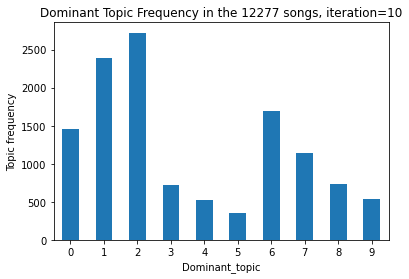

In [46]:
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_Lyrics'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} songs, iteration=10'.format(len(df)),
        ylabel='Topic frequency'); 
plt.savefig("../figures/topic_distribution_iteration_10")

In [ ]:
representatives = pd.DataFrame()

pd.set_option("max_colwidth", 150)

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])
    
representatives

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive



def f(idx):
    print('Document: {}  Dominant topic: {}\n'.format(representatives.index[idx], 
                                       representatives.loc[representatives.index[idx]]['Dominant_topic']))
    print(df['lyrics'][representatives.index[idx]])

    
interactive(f, idx = widgets.Dropdown(options=[0,1,2,3,4], value=0, description='topic id'))

In [ ]:
coherence_scores = []
"""
for n in range(3, 50, 2):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))

coherence_scores
"""

In [ ]:
sns.set()
num_topic = [coherence[0] for coherence in coherence_scores]
score = [coherence[1] for coherence in coherence_scores]
sns.lineplot(x=num_topic, y=score).set(ylabel='coherence score', xlabel='num_topic',xticks=range(3,50,2));
#plt.savefig("../figures/num_topics_vs_coherence.png")